In [1]:
import pickle
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning
#from disp import ADE,FDE,prediction_displacement,ADE_double_coordinates,FDE_double_coordinates,prediction_displacement_double


In [2]:
def ADE(pred,truth): 
    counter=0
    sum=0
    pred = pd.DataFrame(pred.cpu().numpy())
    truth = pd.DataFrame(truth.cpu().numpy())
    print(pred.shape)
    for i in range(len(pred)):
        half=int(len(pred[i])/2)
        for j in range (half):

            a = np.array((pred[i][j] , pred[i][half+j]))
            b = np.array((truth.iloc[i][j] , truth.iloc[i][half+j]))

            dist = np.linalg.norm(a-b)
            sum+=dist
            counter+=1
            #print("Distance between",a," and ",b," is: ",dist)

    return (sum/counter)
def FDE_Single(pred,truth): 
    counter=0
    sum=0
    pred = pred.cpu().numpy()
    truth = truth.cpu().numpy()

    for ai,bi in zip(pred,truth):
        # print(ai,bi)
        dist = np.linalg.norm(ai-bi)
        sum+=dist
        counter+=1
    return (sum/counter)


def show_error_single(prediction_train,prediction_test,train_target,test_target):
                # # Show error rate
        print("AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Train: ",prediction_displacement(train_target))
        print("AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Test: ",prediction_displacement(test_target))
        print("////////////////////////////////////////////////")
        #average_displacement_error
        print("ADE ERROR RATE TEST: ", FDE_Single(prediction_test,test_target))
        #average_displacement_error
        print("ADE ERROR RATE TRAIN: ", FDE_Single(prediction_train,train_target))
        print("//////////////////////////////////////////")
        #Final_displacement_error
        print("FDE ERROR RATE TEST: ", FDE_Single(prediction_test,test_target))
        print("FDE ERROR RATE TRAIN: ", FDE_Single(prediction_train,train_target))

In [3]:
import numpy as np
import pandas as pd
# Predict error
# Average Displacement error

def ADE(pred,truth): 
    counter=0
    sum=0
    for i in range(len(pred)):
        half=int(len(pred[i])/2)
        for j in range (half):

            a = np.array((pred[i][j] , pred[i][half+j]))
            b = np.array((truth.iloc[i][j] , truth.iloc[i][half+j]))

            dist = np.linalg.norm(a-b)
            sum+=dist
            counter+=1
            #print("Distance between",a," and ",b," is: ",dist)

    return (sum/counter)
def prediction_displacement_double(pred): 
          
        sum=0
        counter=0        
        pred=np.array(pred)
        last_index= (len(pred[0])-1)
        
        for i in range(len(pred)):
                
                    a = np.array((pred[i][0][0] , pred[i][0][1]))
                    b = np.array((pred[i][last_index][0] , pred[i][last_index][1]))

                    dist = np.linalg.norm(a-b)
                    sum+=dist
                    counter+=1
        return (sum/counter)

def prediction_displacement(pred): 
    counter=0
    sum=0
    pred=np.array(pred)
    for i in range(len(pred)):
        half=int(len(pred[i])/2)
        last=(len(pred[i]) - 1)

        a = np.array((pred[i][0] , pred[i][half]))
        b = np.array((pred[i][half-1] , pred[i][last]))

        dist = np.linalg.norm(a-b)
        sum+=dist
        counter+=1
        #print("FDE Distance between",a," and ",b," is: ",dist)
            
    return (sum/counter)
def FDE(pred,truth): 
    counter=0
    sum=0
    for i in range(len(pred)):
        half=int(len(pred[i])/2)
        last=(len(pred[i]) - 1)

        a = np.array((pred[i][half-1] , pred[i][last]))
        b = np.array((truth.iloc[i][half-1] , truth.iloc[i][last]))

        dist = np.linalg.norm(a-b)
        sum+=dist
        counter+=1
        #print("FDE Distance between",a," and ",b," is: ",dist)
            
    return (sum/counter)


def FDE_double_coordinates(pred,truth):
          
        sum=0
        counter=0
        
        pred=np.array(pred)
        truth=np.array(truth)
        last_index= (len(pred[0])-1)

        for i in range(len(pred)):
                
            a = np.array((pred[i][last_index][0] , pred[i][last_index][1]))
            b = np.array((truth[i][last_index][0] , truth[i][last_index][1]))

            dist = np.linalg.norm(a-b)
            sum+=dist
            counter+=1

                # for j in range (len(pred[i])):
                #    pred_x.append(pred[i][j][0])  
                #    pred_y.append(pred[i][j][1]) 

                #    truth_x.append(truth[i][j][0])  
                #    truth_y.append(truth[i][j][1])
        return (sum/counter)
def ADE_double_coordinates(pred,truth):
          
        sum=0
        counter=0
        
        pred=np.array(pred)
        truth=np.array(truth)

        for i in range(len(pred)):
                
                for j in range (len(pred[i])):

                    a = np.array((pred[i][j][0] , pred[i][j][1]))
                    b = np.array((truth[i][j][0] , truth[i][j][1]))

                    dist = np.linalg.norm(a-b)
                    sum+=dist
                    counter+=1
        return (sum/counter)

In [4]:
def load_data():
    with open('train_input.pickle', 'rb') as data:
     train_input = pickle.load(data)
    with open('validate_input.pickle', 'rb') as data:
         validate_input= pickle.load(data)
    with open('test_input.pickle', 'rb') as data:
         test_input = pickle.load(data)
    with open('train_target.pickle', 'rb') as data:
          train_target = pickle.load(data)
    with open('validate_target.pickle', 'rb') as data:
          validate_target = pickle.load(data)
    with open('test_target.pickle', 'rb') as data:
         test_target = pickle.load(data)
    return torch.tensor(train_input,dtype=torch.float32), torch.tensor(validate_input,dtype=torch.float32), torch.tensor(test_input,dtype=torch.float32), torch.tensor(train_target,dtype=torch.float32), torch.tensor(validate_target,dtype=torch.float32), torch.tensor(test_target,dtype=torch.float32)

In [5]:
train_input,validate_input,test_input,train_target,validate_target,test_target=load_data()
print("Train shape: " ,train_target.shape)

Train shape:  torch.Size([5099, 8, 2])


In [6]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        # Load data and get label
        X = self.x[index]
        y = self.y[index]

        return X, y

In [7]:
train_dataset= Dataset(train_input, train_target)
test_dataset= Dataset(test_input, test_target)

In [8]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork, self).__init__()
        self.output_shape = (8,2)
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1,self.output_shape)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8*2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 8*2),
        )

    def forward(self, x):
        x = self.flatten(x)
        # print(x[0])
        logits = self.linear_relu_stack(x)
        out = self.unflatten(logits)
        # print(out[0])
        return out

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
model = LinearNetwork().to(device)
print(model)

LinearNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (unflatten): Unflatten(dim=1, unflattened_size=(8, 2))
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=16, bias=True)
  )
)


In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())

In [12]:
train_input. requires_grad = True
train_input = train_input.to(device)
train_target = train_target.to(device)
train_input. requires_grad 

True

In [13]:
def train():
    for epoch in range(3000):
        y_pred = model(train_input) # make a prediction
        loss = loss_fn(y_pred,train_target) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.data)

train()

0 tensor(42.4832, device='cuda:0')
300 tensor(1.4015, device='cuda:0')
600 tensor(1.8944, device='cuda:0')
900 tensor(1.1881, device='cuda:0')
1200 tensor(0.5988, device='cuda:0')
1500 tensor(1.2285, device='cuda:0')
1800 tensor(1.5880, device='cuda:0')
2100 tensor(0.4642, device='cuda:0')
2400 tensor(0.4649, device='cuda:0')
2700 tensor(0.8744, device='cuda:0')


In [14]:
def show_error_double(prediction_train,prediction_test,train_target,test_target):
                # # Show error rate
        print("AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Train: ",prediction_displacement_double(train_target))
        print("AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Test: ",prediction_displacement_double(test_target))
             
        #average_displacement_error
        print("ADE ERROR RATE TEST: ", ADE_double_coordinates(prediction_test,test_target))
        #average_displacement_error
        print("ADE ERROR RATE TRAIN: ", ADE_double_coordinates(prediction_train,train_target))
        print("//////////////////////////////////////////")
        #Final_displacement_error
        print("FDE ERROR RATE TEST: ", FDE_double_coordinates(prediction_test,test_target))
        print("FDE ERROR RATE TRAIN: ", FDE_double_coordinates(prediction_train,train_target))


In [15]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units,out_features=16,isseq=True):
        super().__init__()
        self.seq = isseq
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=out_features)

    def forward(self, x):
        batch_size = x.shape[0]
        # print("batch_size",batch_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        if(self.seq):
            out = self.linear(hn[0]).reshape(batch_size,8,2) # First dim of Hn is num_layers, which is set to 1 above.
        else:
            out = self.linear(hn[0])
        return out

In [16]:
learning_rate = 5e-5
num_hidden_units = 16
hidden_size = 12
n_features = 2
num_layers = 1
batch_size = 5

LSTM_model = ShallowRegressionLSTM(num_features=n_features, hidden_units=num_hidden_units).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)

In [18]:
def train_model(data_loader, model, loss_function, optimizer,epochs=10):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for i in range (epochs):
        total_loss = 0
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(output.shape)
            # print(y.shape)
            loss = loss_function(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        if (i+1)%5 == 0:
            print(f"Epoch {i+1} train loss: {avg_loss}")
    print(f"Epoch {i+1} train loss: {avg_loss}")

In [19]:
train_model(train_loader, LSTM_model, loss_function, optimizer,epochs=96)

Epoch 5 train loss: 12.491618562650446
Epoch 10 train loss: 5.979350595190829
Epoch 15 train loss: 4.7102795102304835
Epoch 20 train loss: 3.953763326553299
Epoch 25 train loss: 3.3716476714480486
Epoch 30 train loss: 2.8504271227629014
Epoch 35 train loss: 2.345807111868635
Epoch 40 train loss: 1.8168156178558574
Epoch 45 train loss: 1.3237695597084786
Epoch 50 train loss: 0.9389004541478831
Epoch 55 train loss: 0.694685316720393
Epoch 60 train loss: 0.5411829444112978
Epoch 65 train loss: 0.4398331676489975
Epoch 70 train loss: 0.36982810738982685
Epoch 75 train loss: 0.3211702946005115
Epoch 80 train loss: 0.28759743698476586
Epoch 85 train loss: 0.2640571870075826
Epoch 90 train loss: 0.24684564276845491
Epoch 95 train loss: 0.2335837020845764
Epoch 96 train loss: 0.23126802532494242


In [20]:
with torch.no_grad():
    test_input = test_input.to(device)
    test_pred = LSTM_model(test_input)
    train_pred = LSTM_model(train_input)
    loss = loss_fn(test_target.to(device), test_pred)
    print(loss.data)

tensor(0.3620, device='cuda:0')


In [28]:
train_pred = train_pred.cpu()
test_pred = test_pred.cpu()
train_target = train_target.cpu()
test_target = test_target.cpu()
show_error_double(train_pred,test_pred,train_target,test_target)

AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Train:  1.7491152588806866
AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Test:  2.7941778349259665
ADE ERROR RATE TEST:  0.6753567187978511
ADE ERROR RATE TRAIN:  0.6038684342316215
//////////////////////////////////////////
FDE ERROR RATE TEST:  0.9912168919241945
FDE ERROR RATE TRAIN:  0.9114254694895947


In [22]:
# Predicting only one point in the future
train_target_one = train_target[:,0,:]
test_target_one = test_target[:,0,:]
train_dataset_one= Dataset(train_input, train_target_one)
test_dataset_one= Dataset(test_input, test_target_one)
train_loader_one = torch.utils.data.DataLoader(train_dataset_one, batch_size)
test_loader_one = torch.utils.data.DataLoader(test_dataset_one, batch_size)

In [23]:
learning_rate = 5e-5
num_hidden_units = 16
hidden_size = 12
n_features = 2
num_layers = 1
batch_size = 5

LSTM_model2 = ShallowRegressionLSTM(num_features=n_features, hidden_units=num_hidden_units,out_features=2,isseq=False).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model2.parameters(), lr=learning_rate)

In [24]:
train_model(train_loader_one, LSTM_model2, loss_function, optimizer,epochs=96)

Epoch 5 train loss: 7.8207986168344235
Epoch 10 train loss: 2.9354971282339344
Epoch 15 train loss: 1.6785979251317935
Epoch 20 train loss: 0.8806190938991337
Epoch 25 train loss: 0.4690567978283605
Epoch 30 train loss: 0.26560317042733056
Epoch 35 train loss: 0.16445865940956417
Epoch 40 train loss: 0.11230330844314534
Epoch 45 train loss: 0.0824782337917182
Epoch 50 train loss: 0.06326309477695116
Epoch 55 train loss: 0.04993063369036766
Epoch 60 train loss: 0.0401968464482676
Epoch 65 train loss: 0.0328324758031673
Epoch 70 train loss: 0.027111867316104696
Epoch 75 train loss: 0.022569252421896085
Epoch 80 train loss: 0.018918517913171885
Epoch 85 train loss: 0.01600040433485476
Epoch 90 train loss: 0.0137206867074666
Epoch 95 train loss: 0.011969883987706932
Epoch 96 train loss: 0.011670654579058169


In [25]:
with torch.no_grad():
    test_pred_one= LSTM_model2(test_input)
    train_pred_one = LSTM_model2(train_input)
    loss_train = loss_fn(train_target_one.to(device), train_pred_one)
    loss_test = loss_fn(test_target_one.to(device), test_pred_one)
    print(f'loss_train: {loss_train.data} \nloss_test: {loss_test.data}')

loss_train: 0.011891846545040607 
loss_test: 0.02230851724743843


In [26]:
train_pred_one = train_pred_one.cpu()
test_pred_one = test_pred_one.cpu()
train_target_one = train_target_one.cpu()
test_target_one = test_target_one.cpu()
show_error_single(train_pred_one,test_pred_one,train_target_one,test_target_one)

AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Train:  0.0
AVERAGE DISTANCE BETWEEN FIRST AND LAST POINT Test:  0.0
////////////////////////////////////////////////
ADE ERROR RATE TEST:  0.14243410510810472
ADE ERROR RATE TRAIN:  0.10414738581315118
//////////////////////////////////////////
FDE ERROR RATE TEST:  0.14243410510810472
FDE ERROR RATE TRAIN:  0.10414738581315118


# Gaussian Distribution Functions

In [29]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    print("result1: ",result.shape)
    result = torch.sum(result, dim=1)
    print("result after sum: ",result.shape)
    result = -torch.log(result)
    print("result after log: ",result.shape)
    return torch.mean(result)

In [72]:
class MDN(nn.Module):
    def __init__(self,n_hidden, n_gaussians,input_shape = 16):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(input_shape, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians).to(device)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians).to(device)
        self.z_mu = nn.Linear(n_hidden, n_gaussians).to(device)  

    def forward(self, x):
        print("x.shape: ",x.shape)
        z_h = self.z_h(x).to(device)
        pi = nn.functional.softmax(self.z_pi(z_h), -1).to(device)
        sigma = torch.exp(self.z_sigma(z_h)).to(device)
        mu = self.z_mu(z_h).to(device)
        return pi, sigma, mu

In [73]:
network = MDN(n_hidden=20, n_gaussians=5).to(device)

In [74]:
network.parameters

<bound method Module.parameters of MDN(
  (z_h): Sequential(
    (0): Linear(in_features=16, out_features=20, bias=True)
    (1): Tanh()
  )
  (z_pi): Linear(in_features=20, out_features=5, bias=True)
  (z_sigma): Linear(in_features=20, out_features=5, bias=True)
  (z_mu): Linear(in_features=20, out_features=5, bias=True)
)>

In [76]:
input = torch.rand(3,8,2).to(device)
# input = torch.rand(8,1).to(device)
input = torch.flatten(input,1)
pi, sigma, mu = network(input)
pi, sigma, mu

x.shape:  torch.Size([3, 16])


(tensor([[0.2373, 0.2017, 0.1277, 0.2424, 0.1908],
         [0.2136, 0.1770, 0.1427, 0.2810, 0.1857],
         [0.1990, 0.1935, 0.1557, 0.2605, 0.1913]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 tensor([[0.7861, 0.7846, 1.5718, 0.8373, 1.3555],
         [0.7534, 0.7882, 1.1083, 0.9331, 1.3785],
         [0.6637, 0.7275, 1.1896, 0.9625, 1.5129]], device='cuda:0',
        grad_fn=<ExpBackward0>),
 tensor([[-0.1885,  0.3146,  0.0279,  0.5617,  0.3669],
         [-0.0890,  0.2002,  0.0723,  0.4279,  0.3924],
         [-0.0491,  0.2665,  0.0586,  0.4024,  0.2599]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [77]:
from torchsummary import summary
input = (10,16)
summary(network,input)

x.shape:  torch.Size([2, 10, 16])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 20]             340
              Tanh-2               [-1, 10, 20]               0
            Linear-3                [-1, 10, 5]             105
            Linear-4                [-1, 10, 5]             105
            Linear-5                [-1, 10, 5]             105
Total params: 655
Trainable params: 655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [137]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# Our 2-dimensional distribution will be over variables X and Y
N = 8
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1.1 , 0.], [0,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


In [142]:
pos.shape

(8, 8, 2)

In [138]:
X.shape

(8, 8)

In [139]:

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N



In [140]:
# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
Z.shape


(8, 8)

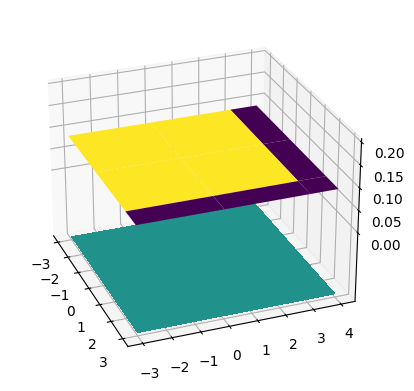

In [141]:

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()